# Cross validation and modelling

# Module import

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import recall_score, precision_recall_curve, average_precision_score, accuracy_score, f1_score

# Load data
- if woe_run = True, it will load woe transformed related preprocessed data
- if woe_run = False, it will load preprocessed data (T3) without woe transformed

In [2]:
woe_run = True

In [3]:
if woe_run:
    data = pickle.load(open( "./woe_data_model/processed_data_woe.p", "rb" ) )
else:
    data = pickle.load(open( "./processed_data_T3.p", "rb" ) )

X = data["X"]
y = data["y"]

# Train test split
- data were split into two set (70%/30%).

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 10, stratify=y)

In [5]:
X.shape

(30000, 23)

# Upsampling
- in the training set, all 1s data points were copied 4 times and added to the original training set

In [6]:
scale_pos_weight = round(sum(abs(y - 1))/sum(y))
data_train = np.concatenate((X_train, np.array([y_train]).T), axis=1)
data_train_positive = data_train[data_train[:,-1]==1,:]
for i in range(scale_pos_weight):
    data_train = np.concatenate((data_train, data_train_positive), axis=0)
data_train.shape

(39580, 24)

# Cross validation
- 5-fold
- optimising c in [10^(-5), 10^(-4), ... , 10**5]
- average_precision (auc_pr)

In [7]:
clf = LogisticRegressionCV(Cs=[10**x for x in range(-5, 5) ], cv=5, random_state=10, scoring="average_precision", max_iter=100)

In [8]:
clf.fit(data_train[:,:-1], data_train[:,-1])
clf.scores_

{1.0: array([[0.81133078, 0.81847344, 0.8225743 , 0.8231178 , 0.82315552,
         0.82315766, 0.82315985, 0.8231601 , 0.82316022, 0.82316013],
        [0.82615315, 0.83336657, 0.83789935, 0.83791922, 0.83791334,
         0.83790296, 0.83790245, 0.83790305, 0.83790147, 0.8379015 ],
        [0.81968843, 0.82818735, 0.8341649 , 0.83501946, 0.83508058,
         0.83508265, 0.83508399, 0.83508381, 0.83508282, 0.83508312],
        [0.81576499, 0.82286076, 0.82727026, 0.8277957 , 0.82780288,
         0.82780739, 0.82780729, 0.82780705, 0.82780744, 0.82780692],
        [0.81948852, 0.82755479, 0.83334619, 0.83389252, 0.83390157,
         0.83389981, 0.83389988, 0.83390057, 0.83390164, 0.83390184]])}

In [9]:
clf.scores_[1].max()

0.8379192201991554

# Test

In [10]:
predictions = clf.predict(X_test)
prob = clf.predict_proba(X_test)

In [11]:
aucpr = average_precision_score(y_test, prob[:,1])

In [12]:
cm = confusion_matrix(y_test, predictions)
recall_val = cm[1,1] / (cm[1,0]+cm[1,1])
recall_val

0.7001506780512305

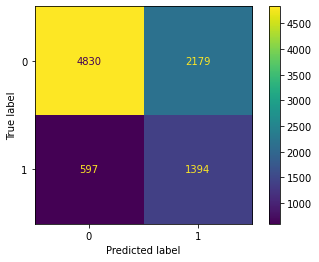

In [13]:
plot_confusion_matrix(clf, X_test, y_test)

# Save the model
without woe ->  T3 processed model: "./model_cv_lgc.p"

with woe -> woe processed model: "./woe_data_model/model_woe_lgc.p"

In [107]:
pickle.dump({"clf": clf}, open("./woe_data_model/model_woe_lgc.p", "wb"))

# Results
### no woe 
- cross validation, best aucpr : 0.8217554439679058 
- test_data, aucpr :0.49876507124900915 recall : 0.6695128076343546

### with woe
- cross validation, best aucpr : 0.8376307650768446
- test_data aucpr : 0.5313492721419514 recall: 0.7001506780512305